In [1]:
%%capture
!apt-get update && apt-get install -y libsm6 libxext6 libxrender-dev
!pip install opencv-contrib-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import glob
from PIL import Image
from collections import defaultdict
import math
from copy import deepcopy
import pandas as pd
import struct, os
import re, numpy as np
# from skimage import transform
import itertools, operator
from torch.optim.lr_scheduler import _LRScheduler

import os
import sys
import xml.etree.ElementTree as ET
import glob

import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [3]:
# Create Yolo v2 config
# Load pre-trained weights from darknet 23 layer
# Understand the Yolo v2 training process 
#            - Data Aug
#            - Multi Scale Training
#            - Loss Fn
#            - Learning Rate
#            - Optimizer setting
# 
# Understand how the model requires <input, labels> feed dict
# Read PASCAL data in the format needed
# Training

In [4]:
# Data Augmentation
# Transforms classes
# Random scale
# Flip
# x, y reposition
class RandomCrop(object):
    
    def imcv2_affine_trans(self, im):
        # Scale and translate
        h, w, c = im.shape
        scale = np.random.uniform() / 10. + 1.
        max_offx = (scale-1.) * w
        max_offy = (scale-1.) * h
        offx = int(np.random.uniform() * max_offx)
        offy = int(np.random.uniform() * max_offy)

        im = cv2.resize(im, (0,0), fx = scale, fy = scale)
        im = im[offy : (offy + h), offx : (offx + w)]

        return im, [w, h], [scale, [offx, offy]]

    
    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']
        result = self.imcv2_affine_trans(image)
        image, dims, trans_param = result
        scale, offs = trans_param
        
        offs = np.array(offs*2)
        dims = np.array(dims*2)
        bboxes = deepcopy(bboxes)
        bboxes[:, 1:] = np.array(bboxes[:, 1:]*scale - offs, np.int64)
        bboxes[:, 1:] = np.maximum(np.minimum(bboxes[:, 1:], dims), 0)
        
        check_errors = (((bboxes[:, 1] >= bboxes[:, 3]) | (bboxes[:, 2] >= bboxes[:, 4])) & (bboxes[:, 0]!=-1))
        if sum(check_errors) > 0:
            bool_mask = ~ check_errors
            bboxes = bboxes[bool_mask]
        return {"image": image, "bboxes": bboxes}

class RandomFlip(object):
    
    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']

        bboxes = deepcopy(bboxes)
        flip = np.random.binomial(1, .5)
        if flip: 
            w = image.shape[1]
            image = cv2.flip(image, 1)
            backup_min = deepcopy(bboxes[:, 1])
            bboxes[:, 1] = w - bboxes[:, 3]
            bboxes[:, 3] = w - backup_min
        
        if sum(((bboxes[:, 1] >= bboxes[:, 3]) | (bboxes[:, 2] >= bboxes[:, 4])) & (bboxes[:, 0]!=-1)) > 0:
            print ("random flip")
        
        return {"image": image, "bboxes": bboxes}

class Rescale(object):
    
    def __init__(self, output):
        self.new_h, self.new_w = output
        
    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']
        h, w, c = image.shape
        new_h = int(self.new_h)
        new_w = int(self.new_w)
        image = cv2.resize(image, (new_w, new_h))
        
        bboxes = deepcopy(bboxes)
        bboxes = np.array(bboxes, np.float64)
        bboxes[:, 1] *= new_w*1.0/w
        bboxes[:, 2] *= new_h*1.0/h
        bboxes[:, 3] *= new_w*1.0/w
        bboxes[:, 4] *= new_h*1.0/h
        if sum(((bboxes[:, 1] >= bboxes[:, 3]) | (bboxes[:, 2] >= bboxes[:, 4])) & (bboxes[:, 0]!=-1)) > 0:
            print ("random scale", bboxes, sample['bboxes'], new_w, new_h, w, h)

        return {"image": image, "bboxes": bboxes}

class TransformBoxCoords(object):
    
    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']
        height, width, _ = image.shape
        
        bboxes = deepcopy(bboxes)
        bboxes = np.array(bboxes, np.float64)
        x = 0.5 * (bboxes[:, 1] + bboxes[:, 3])
        y = 0.5 * (bboxes[:, 2] + bboxes[:, 4])
        w = 1. * (bboxes[:, 3] - bboxes[:, 1])
        h = 1. * (bboxes[:, 4] - bboxes[:, 2])
        if sum(((w <= 0) | (h <= 0) | (x <= 0) | (y <= 0)) & (bboxes[:, 0]!=-1))>0:
            print ("up", bboxes, sample["bboxes"])
        bboxes[:, 1] = x/width
        bboxes[:, 2] = y/height
        bboxes[:, 3] = w/width
        bboxes[:, 4] = h/height
        if sum(((bboxes[:, 1] <0) | (bboxes[:, 2]<0) | (bboxes[:, 3]<=0) | (bboxes[:, 4]<=0)) & (bboxes[:, 0]!=-1)) > 0:
            print ("random transform box coords")

        
        return {"image": image, "bboxes": bboxes}

class Normalize(object):
    
    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']
        image = np.array(image, np.float64)
        image /= 255.0
        return {"image": image, "bboxes": bboxes}

class EliminateSmallBoxes(object):
    
    def __init__(self, thresh):
        self.thresh = thresh

    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']
        bool_mask = ((bboxes[: , 3] > self.thresh) & (bboxes[: , 4] > self.thresh))
        bboxes = bboxes[bool_mask]
        return {"image": image, "bboxes": bboxes}


class ToTensor(object):

    def __call__(self, sample):
        image, bboxes = sample['image'], sample['bboxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
        if len(bboxes) == 0:
            return {'image': torch.from_numpy(image), 'bboxes': torch.DoubleTensor()}
        return {'image': torch.from_numpy(image), 'bboxes': torch.from_numpy(bboxes)}


In [5]:
classes =  np.array(['sheep', 'horse', 'bicycle', 'bottle', 'cow', 'sofa', 'car', 'dog', 'cat', 'person', 'train', 'diningtable', 'aeroplane', 'bus', 'pottedplant', 'tvmonitor', 'chair', 'bird', 'boat', 'motorbike'])

In [54]:
test_loader.dataset.folderpath

'./data/test/VOCdevkit/VOC2012/'

In [56]:
names = glob.glob('./data/test/VOCdevkit/VOC2012/'+"/JPEGImages/*.jpg")
imagenames = [re.split("\\.", re.split("\\/", names[i])[-1])[0] for i in range(len(names))]

In [57]:
imagenames

['2008_008699',
 '2010_004633',
 '2008_004211',
 '2008_003555',
 '2008_004294',
 '2012_003471',
 '2008_005030',
 '2009_002095',
 '2012_002039',
 '2011_003840',
 '2008_006905',
 '2011_001494',
 '2010_004736',
 '2011_003248',
 '2012_002680',
 '2012_002231',
 '2009_004549',
 '2009_001459',
 '2011_001478',
 '2012_003312',
 '2012_001936',
 '2012_004128',
 '2008_000344',
 '2011_001379',
 '2008_006165',
 '2009_002786',
 '2011_004608',
 '2010_000835',
 '2012_000685',
 '2009_005277',
 '2008_004405',
 '2008_004650',
 '2011_005279',
 '2011_003835',
 '2012_001574',
 '2012_001464',
 '2009_001923',
 '2011_005350',
 '2009_001766',
 '2011_000367',
 '2008_006266',
 '2008_005326',
 '2009_004636',
 '2011_001985',
 '2010_004134',
 '2009_002810',
 '2011_000697',
 '2010_005994',
 '2012_001751',
 '2010_002013',
 '2011_007147',
 '2011_006711',
 '2008_003649',
 '2010_001389',
 '2009_003332',
 '2011_006791',
 '2009_002132',
 '2010_000115',
 '2010_000126',
 '2008_006757',
 '2009_005029',
 '2008_005506',
 '2008_0

In [58]:
names[:5]

['./data/test/VOCdevkit/VOC2012//JPEGImages/2008_008699.jpg',
 './data/test/VOCdevkit/VOC2012//JPEGImages/2010_004633.jpg',
 './data/test/VOCdevkit/VOC2012//JPEGImages/2008_004211.jpg',
 './data/test/VOCdevkit/VOC2012//JPEGImages/2008_003555.jpg',
 './data/test/VOCdevkit/VOC2012//JPEGImages/2008_004294.jpg']

In [61]:
list(set(imagenames) & set(voc_2007[0].values))

[]

In [6]:
class VOCDataset(Dataset):
    
    def __init__(self, folderpath, sample=-1, transform=None, files = [], max_truth=30):
        
        """
            Reading all image names without the extension.
        """
        names = glob.glob(folderpath+ "/JPEGImages/*.jpg")
        self.imagenames = [re.split("\\.", re.split("\\/", names[i])[-1])[0] for i in range(len(names))]
        self.imagenames = list(set(self.imagenames) & set(files))
        np.random.shuffle(self.imagenames)
        if sample != -1:
            self.imagenames = self.imagenames[:sample]
        self.folderpath = folderpath
        self.transform = transform
        self.max_truth = max_truth
    
    def __len__(self):
        return len(self.imagenames)
    
    
    def parse_xml(self, xml_file):
        # actual parsing 
        in_file = open(xml_file)
        tree = ET.parse(in_file)
        root = tree.getroot()
        imsize = root.find('size')
        w = int(imsize.find('width').text)
        h = int(imsize.find('height').text)
        all_bboxes = list()

        for obj in root.iter('object'):
            current = list()
            name = obj.find('name').text
            
            class_id = np.argwhere(classes==name)[0][0]
            
            xmlbox = obj.find('bndbox')
            xn = int(float(xmlbox.find('xmin').text))
            xx = int(float(xmlbox.find('xmax').text))
            yn = int(float(xmlbox.find('ymin').text))
            yx = int(float(xmlbox.find('ymax').text))
            current = np.array([class_id,xn,yn,xx,yx])
            all_bboxes += [current]
        
        in_file.close()
        return np.array(all_bboxes)

    
    def __getitem__(self, idx):
        imagename = self.imagenames[idx]
        image_file = os.path.join(self.folderpath, "JPEGImages", imagename + ".jpg")
        annotation_file = os.path.join(self.folderpath, "Annotations", imagename + ".xml")
        
        bboxes = self.parse_xml(annotation_file)
        
        img_array = np.asarray(Image.open(open(image_file)))
        datum = {"image": img_array, "bboxes": bboxes}
            
        if self.transform:
            datum = self.transform(datum)

        bboxes = datum['bboxes'].numpy()
        
        n_true = len(bboxes)
        if len(bboxes) > self.max_truth:
            bboxes = bboxes[:self.max_truth]
            n_true = self.max_truth
        else:
            zero_fill = self.max_truth - len(bboxes)
            null_pad = -1 * (np.ones(5*zero_fill).reshape(zero_fill, 5))
            if n_true == 0:
                bboxes = null_pad
            else:
                bboxes = np.concatenate([bboxes, null_pad])
        
        datum['bboxes'] = torch.from_numpy(bboxes)
        datum['n_true'] = n_true
        return datum
    

In [7]:
train2012 = pd.read_csv("./data/train/VOCdevkit/VOC2012/ImageSets/Main/train.txt", 
                        sep='\s+', header=-1)
val2012 = pd.read_csv("./data/train/VOCdevkit/VOC2012/ImageSets/Main/val.txt", 
                      sep='\s+', header=-1)
voc_train2012 = pd.concat([train2012, val2012]).drop_duplicates()

voc_train2012.columns = ['filepath']
voc_train2012["train"] = 1

voc_2012 = pd.DataFrame({"filepath":
                         glob.glob("./data/train/VOCdevkit/VOC2012/JPEGImages/*.jpg")})
voc_2012["filepath"] = voc_2012['filepath'].map(lambda x: re.split("\\.", re.split("\\/", x)[-1])[0])
voc_2012 = pd.merge(voc_2012, voc_train2012, on="filepath", how="left")
voc_2012.fillna(0, inplace=True)

#### 
# 2007 dataset
########
train_2007 = pd.read_csv("./data/train/VOCdevkit/VOC2007/ImageSets/Main/train.txt", sep='\s+', header=-1, dtype='str')
val_2007 = pd.read_csv("./data/train/VOCdevkit/VOC2007/ImageSets/Main/val.txt", sep='\s+', header=-1, dtype='str')
test_2007 = pd.read_csv("./data/test/VOCdevkit/VOC2007/ImageSets/Main/test.txt", sep='\s+', header=-1, dtype='str')

voc_2007 = pd.concat([train_2007, val_2007, test_2007]).drop_duplicates()
voc_2007.drop_duplicates(inplace=True)

In [41]:
def get_data(image_size=416, sample=-1, batch_size=64):
    transform_fn = transforms.Compose([RandomCrop(), 
                                   RandomFlip(), 
                                   Rescale((image_size, image_size)), 
                                   TransformBoxCoords(), 
                                   Normalize(),
                                   EliminateSmallBoxes(0.025),
                                   ToTensor()])
    
    voc_train_12 = VOCDataset("./data/train/VOCdevkit/VOC2012/", sample=sample, transform=transform_fn,
                        files=voc_2012[voc_2012["train"]==1]["filepath"].values)
    voc_test_12 = VOCDataset("./data/test/VOCdevkit/VOC2012/", sample=sample, transform=transform_fn,
                            files=voc_2012[voc_2012["train"]==0]["filepath"].values)
    voc_train_07 = VOCDataset("./data/train/VOCdevkit/VOC2007/", sample=sample, transform=transform_fn,
                            files=voc_2007[0].values)
#     voc_test_07 = VOCDataset("./data/test/VOCdevkit/VOC2007/", sample=sample, transform=transform_fn,
#                             files=voc_2007[voc_2007["train"]==0]["filepath"].values)

    # Dataloader
    
    train_loader = DataLoader(ConcatDataset([voc_train_07, voc_train_12]), 
                              batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(voc_test_12, batch_size=batch_size, num_workers=4)
    return train_loader, test_loader

In [9]:
# class define for conv, maxpool and others
class Yolov2(nn.Module):
    
    def __init__(self):
        super(Yolov2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm8 = nn.BatchNorm2d(256)
        
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm9 = nn.BatchNorm2d(512)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm11 = nn.BatchNorm2d(512)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm12 = nn.BatchNorm2d(256)
        self.conv13 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm13 = nn.BatchNorm2d(512)
        
        self.conv14 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm14 = nn.BatchNorm2d(1024)
        self.conv15 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm15 = nn.BatchNorm2d(512)
        self.conv16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm16 = nn.BatchNorm2d(1024)
        self.conv17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm17 = nn.BatchNorm2d(512)
        self.conv18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm18 = nn.BatchNorm2d(1024)

        self.conv19 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm19 = nn.BatchNorm2d(1024)
        self.conv20 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm20 = nn.BatchNorm2d(1024)
        
        self.conv21 = nn.Conv2d(in_channels=3072, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm21 = nn.BatchNorm2d(1024)
        
        self.conv22 = nn.Conv2d(in_channels=1024, out_channels=125, kernel_size=1, stride=1, padding=0)
        
    def reorg_layer(self, x):
        stride = 2
        batch_size, channels, height, width = x.size()
        new_ht = height/stride
        new_wd = width/stride
        new_channels = channels * stride * stride
        
        passthrough = x.permute(0, 2, 3, 1)
        passthrough = passthrough.contiguous().view(-1, new_ht, stride, new_wd, stride, channels)
        passthrough = passthrough.permute(0, 1, 3, 2, 4, 5)
        passthrough = passthrough.contiguous().view(-1, new_ht, new_wd, new_channels)
        passthrough = passthrough.permute(0, 3, 1, 2)
        return passthrough

    def forward(self, x):
        out = F.max_pool2d(F.leaky_relu(self.batchnorm1(self.conv1(x)), negative_slope=0.1), 2, stride=2)
        out = F.max_pool2d(F.leaky_relu(self.batchnorm2(self.conv2(out)), negative_slope=0.1), 2, stride=2)
        
        out = F.leaky_relu(self.batchnorm3(self.conv3(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm4(self.conv4(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm5(self.conv5(out)), negative_slope=0.1)
        out = F.max_pool2d(out, 2, stride=2)
        
        out = F.leaky_relu(self.batchnorm6(self.conv6(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm7(self.conv7(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm8(self.conv8(out)), negative_slope=0.1)
        out = F.max_pool2d(out, 2, stride=2)

        out = F.leaky_relu(self.batchnorm9(self.conv9(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm10(self.conv10(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm11(self.conv11(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm12(self.conv12(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm13(self.conv13(out)), negative_slope=0.1)
        passthrough = self.reorg_layer(out)
        out = F.max_pool2d(out, 2, stride=2)

        out = F.leaky_relu(self.batchnorm14(self.conv14(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm15(self.conv15(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm16(self.conv16(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm17(self.conv17(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm18(self.conv18(out)), negative_slope=0.1)

        out = F.leaky_relu(self.batchnorm19(self.conv19(out)), negative_slope=0.1)
        out = F.leaky_relu(self.batchnorm20(self.conv20(out)), negative_slope=0.1)
        
        out = torch.cat([passthrough, out], 1)
        out = F.leaky_relu(self.batchnorm21(self.conv21(out)), negative_slope=0.1)
        out = self.conv22(out)

        return out


In [10]:
# def load_pretrained_weights(model):
#     group_mapping = defaultdict(lambda: defaultdict())
#     cnt = 0
#     for child in model.children():
#         if type(child) == nn.Conv2d:
#             cnt += 1
#             if cnt > 18:
#                 break
#             group_mapping[cnt]['conv'] = child
#             group_mapping[cnt]['bias'] = child
#         else:
#             group_mapping[cnt]['bias'] = child


#     f = open('../darknet19_448.conv.23', 'rb')
# #     f = open('../yolo.weights', 'rb')
#     major, minor, revision, seen = struct.unpack('4i', f.read(16))
#     for i in range(1, 19):

#         bias_var = group_mapping[i]['bias']
#         cnt = int(bias_var.bias.size()[0])
#         bias_var.bias.data = torch.from_numpy(np.array(struct.unpack('%df' % cnt, f.read(4*cnt)))).float()
#         bias_var.weight.data = torch.from_numpy(np.array(struct.unpack('%df' % cnt, f.read(4*cnt)))).float()
#         bias_var.running_mean = torch.from_numpy(np.array(struct.unpack('%df' % cnt, f.read(4*cnt)))).float()
#         bias_var.running_var = torch.from_numpy(np.array(struct.unpack('%df' % cnt, f.read(4*cnt)))).float()

#         for param in bias_var.parameters():
#             param.requires_grad = False

#         conv_var = group_mapping[i]['conv']
#         c_out, c_in, f1, f2 = conv_var.weight.size()
#         cnt = int(c_out * c_in * f1 * f2)
#         p = struct.unpack('%df' % cnt, f.read(4*cnt))
#         conv_var.weight.data = torch.from_numpy(np.reshape(p, [c_out, c_in, f1, f2])).float()
#         for param in conv_var.parameters():
#             param.requires_grad = False
    
#     return model


def get_model():
    model = Yolov2()
#     model = load_pretrained_weights(model)
    if torch.cuda.is_available():
        model.cuda()
    return model

    
# def model_freeze_upto(model, layer_x):
#     childs = list(model.children())
#     for i in range(len(childs)):
#         child = childs[i]
#         for param in child.parameters():
#             if i < layer_x:
#                 param.requires_grad = False
#             else:
#                 param.requires_grad = True
    
    

In [11]:
def bbox_overlap_iou(bboxes1, bboxes2, is_anchor):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----        
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
#     import pdb; pdb.set_trace()
    x1, y1, w1, h1 = bboxes1.chunk(4, dim=-1)
    x2, y2, w2, h2 = bboxes2.chunk(4, dim=-1)
    
    x11 = x1 - 0.5*w1
    y11 = y1 - 0.5*h1
    x12 = x1 + 0.5*w1
    y12 = y1 + 0.5*h1
    x21 = x2 - 0.5*w2
    y21 = y2 - 0.5*h2
    x22 = x2 + 0.5*w2
    y22 = y2 + 0.5*h2
    
#     x11 = torch.clamp(x11, min=0, max=1)
#     y11 = torch.clamp(y11, min=0, max=1)
#     x12 = torch.clamp(x12, min=0, max=1)
#     y12 = torch.clamp(y12, min=0, max=1)
#     x21 = torch.clamp(x21, min=0, max=1)
#     y21 = torch.clamp(y21, min=0, max=1)
#     x22 = torch.clamp(x22, min=0, max=1)
#     y22 = torch.clamp(y22, min=0, max=1)
    

    xI1 = torch.max(x11, x21.transpose(1, 0))
    yI1 = torch.max(y11, y21.transpose(1, 0))
    
    xI2 = torch.min(x12, x22.transpose(1, 0))
    yI2 = torch.min(y12, y22.transpose(1, 0))

    inner_box_w = torch.clamp((xI2 - xI1), min=0)
    inner_box_h = torch.clamp((yI2 - yI1), min=0)
    
    inter_area = inner_box_w * inner_box_h
    bboxes1_area = (x12 - x11) * (y12 - y11)
    bboxes2_area = (x22 - x21) * (y22 - y21)

    union = (bboxes1_area + bboxes2_area.transpose(1, 0)) - inter_area
    return torch.clamp(inter_area / union, min=0)


In [12]:
# loss function
def Yolov2Loss(output, labels, n_truths):
    B = meta['anchors']
    C = meta['classes']
    batch_size = meta['batch_size']
    threshold = meta['threshold']
    anchor_bias = meta['anchor_bias']
    scale_no_obj = meta['scale_no_obj']
    scale_coords = meta['scale_coords']
    scale_class = meta['scale_class']
    scale_obj = meta['scale_obj']
    
    H = output.size(2)
    W = output.size(3)
    
    wh = Variable(torch.from_numpy(np.reshape([W, H], [1, 1, 1, 1, 2]))).float()
    anchor_bias_var = Variable(torch.from_numpy(np.reshape(anchor_bias, [1, 1, 1, B, 2]))).float()
    
    w_list = np.array(list(range(W)), np.float32)
    wh_ids = Variable(torch.from_numpy(np.array(list(map(lambda x: np.array(list(itertools.product(w_list, [x]))), range(H)))).reshape(1, H, W, 1, 2))).float() 
    
    zero_pad = Variable(torch.zeros(2).contiguous().view(1, 2)).float()
    pad_var = Variable(torch.zeros(2*B).contiguous().view(B, 2)).float()
    
    loss = Variable(torch.Tensor([0])).float()
    class_zeros = Variable(torch.zeros(C)).float()
    mask_loss = Variable(torch.zeros(H*W*B*5).contiguous().view(H, W, B, 5)).float()
    zero_coords_loss = Variable(torch.zeros(H*W*B*4).contiguous().view(H, W, B, 4)).float()
    zero_coords_obj_loss = Variable(torch.zeros(H*W*B*5).contiguous().view(H, W, B, 5)).float()
    
    if torch.cuda.is_available():
        wh = wh.cuda()
        wh_ids = wh_ids.cuda()
        pad_var = pad_var.cuda()
        zero_pad = zero_pad.cuda()
        anchor_bias_var = anchor_bias_var.cuda()
        
        loss = loss.cuda()
        mask_loss = mask_loss.cuda()
        class_zeros = class_zeros.cuda()
        zero_coords_loss = zero_coords_loss.cuda()
        zero_coords_obj_loss = zero_coords_obj_loss.cuda()
                           

    anchor_bias_var = anchor_bias_var / wh
    anchor_padded = torch.cat([pad_var, anchor_bias_var.contiguous().view(B, 2)], 1)

    predicted = output.permute(0, 2, 3, 1)
    predicted = predicted.contiguous().view(-1, H, W, B, (4 + 1 + C))
    
    sigmoid = torch.nn.Sigmoid()
    softmax = torch.nn.Softmax(dim=4)
    
    adjusted_xy = sigmoid(predicted[:, :, :, :, :2])
    adjusted_obj = sigmoid(predicted[:, :, :, :, 4:5])
    adjusted_classes = softmax(predicted[:, :, :, :, 5:])
    
    adjusted_coords = (adjusted_xy + wh_ids) / wh

    adjusted_wh = torch.exp(predicted[:, :, :, :, 2:4]) * anchor_bias_var
    
    for batch in range(batch_size):
        
        n_true = n_truths[batch]
        if n_true == 0:
            continue

        pred_outputs = torch.cat([adjusted_coords[batch], adjusted_wh[batch]], 3)
        true_labels = labels[batch, :n_true, 1:]
        
        bboxes_iou = bbox_overlap_iou(pred_outputs, true_labels, False)
        
        # objectness loss (if iou < threshold)
        boxes_max_iou = torch.max(bboxes_iou, -1)[0]
        all_obj_mask = boxes_max_iou.le(threshold)
        all_obj_loss = all_obj_mask.unsqueeze(-1).float() *(scale_no_obj * (-1 * adjusted_obj[batch]))
        
        # each anchor box will learn its bias (if batch < 12800)
        all_coords_loss = zero_coords_loss.clone()
        if meta['iteration'] < 12800:
            all_coords_loss = scale_coords * torch.cat([(0.5 - adjusted_xy[batch]), (0 - predicted[batch, :, :, :, 2:4])], -1)
        
        coord_obj_loss = torch.cat([all_coords_loss, all_obj_loss], -1)
        
        batch_mask = mask_loss.clone()
        truth_coord_obj_loss = zero_coords_obj_loss.clone()
        # for every true label and anchor bias
        for truth_iter in torch.arange(n_true):
            truth_iter = int(truth_iter)
            truth_box = labels[batch, truth_iter]
            anchor_select = bbox_overlap_iou(torch.cat([zero_pad.t(), truth_box[3:]], 0).t(), anchor_padded, True)
            
            # find the responsible anchor box
            anchor_id = torch.max(anchor_select, 1)[1]
            
            truth_i = (truth_box[1] * W)
            w_i = truth_i.int() 
            truth_x = truth_i - w_i.float()
            truth_j = (truth_box[2] * H)
            h_j = truth_j.int()
            truth_y = truth_j - h_j.float()
            truth_wh = (truth_box[3:] / anchor_bias_var.contiguous().view(B, 2).index_select(0, anchor_id.long())).log()
            if (truth_wh[0] == Variable( - torch.cuda.FloatTensor([float('inf')]))).data[0] == 1:
                import pdb; pdb.set_trace()
    
            truth_coords = torch.cat([truth_x.unsqueeze(0), truth_y.unsqueeze(0), truth_wh], 1)
            
            predicted_output = predicted[batch].index_select(0, h_j.long()).index_select(1, w_i.long()).index_select(2, anchor_id.long())[0][0][0]
            # coords loss
            pred_xy = adjusted_xy[batch].index_select(0, h_j.long()).index_select(1, w_i.long()).index_select(2, anchor_id.long())[0][0][0]
            pred_wh = predicted_output[2:4]
            pred_coords = torch.cat([pred_xy, pred_wh], 0)
            coords_loss = scale_coords * (truth_coords - pred_coords.unsqueeze(0))
    
            # objectness loss
        
            # given the responsible box - find iou
            iou = bboxes_iou.index_select(0, h_j.long()).index_select(1, w_i.long()).index_select(2, anchor_id.long())[0][0][0][truth_iter]
            obj_loss = scale_obj * (iou - sigmoid(predicted_output[4]))
            truth_co_obj = torch.cat([coords_loss, obj_loss.view(1, 1)], 1)

            # class prob loss
            class_vec = class_zeros.index_fill(0, truth_box[0].long(), 1)
            class_loss = scale_class * (class_vec - torch.nn.Softmax(dim=0)(predicted_output[5:]))
            
            mask_ones = Variable(torch.ones(5)).float()
            if torch.cuda.is_available():
                mask_ones = mask_ones.cuda()
            
            batch_mask[h_j.long(), w_i.long(), anchor_id.long()] = mask_ones
            truth_coord_obj_loss[h_j.long(), w_i.long(), anchor_id.long()] = truth_co_obj
            
            loss += class_loss.pow(2).sum()
#         import pdb; pdb.set_trace()
        batch_coord_obj_loss = batch_mask * truth_coord_obj_loss + (1 - batch_mask) * coord_obj_loss
        
        loss += batch_coord_obj_loss.pow(2).sum()
        
    return loss
    

In [13]:
def get_nms_boxes(output, obj_thresh, iou_thresh):
#     import pdb; pdb.set_trace()
    N, C, H, W = output.size()
    N, C, H, W = int(N), int(C), int(H), int(W)
    B = meta['anchors']
    anchor_bias = meta['anchor_bias']
    n_classes = meta['classes']
    
    # -1 => unprocesse, 0 => suppressed, 1 => retained
    box_tags = Variable(-1 * torch.ones(H*W*B)).float()
    
    wh = Variable(torch.from_numpy(np.reshape([W, H], [1, 1, 1, 1, 2]))).float()
    anchor_bias_var = Variable(torch.from_numpy(np.reshape(anchor_bias, [1, 1, 1, B, 2]))).float()
    
    w_list = np.array(list(range(W)), np.float32)
    wh_ids = Variable(torch.from_numpy(np.array(list(map(lambda x: np.array(list(itertools.product(w_list, [x]))), range(H)))).reshape(1, H, W, 1, 2))).float() 
    
    if torch.cuda.is_available():
        wh = wh.cuda()
        wh_ids = wh_ids.cuda()
        box_tags = box_tags.cuda()
        anchor_bias_var = anchor_bias_var.cuda()                           

    anchor_bias_var = anchor_bias_var / wh

    predicted = output.permute(0, 2, 3, 1)
    predicted = predicted.contiguous().view(N, H, W, B, -1)
    sigmoid = torch.nn.Sigmoid()
    softmax = torch.nn.Softmax(dim=4)
    
    adjusted_xy = sigmoid(predicted[:, :, :, :, :2])
    adjusted_obj = sigmoid(predicted[:, :, :, :, 4:5])
    adjusted_classes = softmax(predicted[:, :, :, :, 5:])
    
    adjusted_coords = (adjusted_xy + wh_ids) / wh
    adjusted_wh = torch.exp(predicted[:, :, :, :, 2:4]) * anchor_bias_var

    batch_boxes = defaultdict()

    for n in range(N):
        
        scores = (adjusted_obj[n] * adjusted_classes[n]).contiguous().view(H*W*B, -1)
    
        class_probs = adjusted_classes[n].contiguous().view(H*W*B, -1)
        class_ids = torch.max(class_probs, 1)[1]
            
        pred_outputs = torch.cat([adjusted_coords[n], adjusted_wh[n]], 3)
        pred_bboxes = pred_outputs.contiguous().view(H*W*B, 4)
        ious = bbox_overlap_iou(pred_bboxes, pred_bboxes, True)
        
        confidences = adjusted_obj[n].contiguous().view(H*W*B)
        # get all boxes with tag -1
        final_boxes = Variable(torch.FloatTensor())
        if torch.cuda.is_available():
            final_boxes = final_boxes.cuda()
   
        for class_id in range(n_classes):
            bboxes_state = ((class_ids==class_id).float() * (scores[:, class_id] > obj_thresh).float() * box_tags).long().float()
        
            while (torch.sum(bboxes_state==-1) > 0).data[0]:
                max_conf, index = torch.max(scores[:, class_id] * (bboxes_state==-1).float(), 0)
                bboxes_state = ((ious[index] < iou_thresh)[0].float() * bboxes_state).long().float()
                bboxes_state[index] = 1

                index_vals = torch.cat([pred_bboxes[index], confidences[index].view(1, 1), class_probs[index]], 1)
                if len(final_boxes.size()) == 0:
                    final_boxes = index_vals
                else:
                    final_boxes = torch.cat([final_boxes, index_vals], 0)
        
        batch_boxes[n] = final_boxes
        
    return batch_boxes
        

In [14]:
# Non Max Suppression
def get_nms_detections(output, obj_thresh, iou_thresh):
#     import pdb; pdb.set_trace()
    N, C, H, W = output.size()
    N, C, H, W = int(N), int(C), int(H), int(W)
    B = meta['anchors']
    anchor_bias = meta['anchor_bias']
    
    # -1 => unprocesse, 0 => suppressed, 1 => retained
    box_tags = Variable(-1 * torch.ones(H*W*B)).float()
    
    wh = Variable(torch.from_numpy(np.reshape([W, H], [1, 1, 1, 1, 2]))).float()
    anchor_bias_var = Variable(torch.from_numpy(np.reshape(anchor_bias, [1, 1, 1, B, 2]))).float()
    
    w_list = np.array(list(range(W)), np.float32)
    wh_ids = Variable(torch.from_numpy(np.array(list(map(lambda x: np.array(list(itertools.product(w_list, [x]))), range(H)))).reshape(1, H, W, 1, 2))).float() 
    
    if torch.cuda.is_available():
        wh = wh.cuda()
        wh_ids = wh_ids.cuda()
        box_tags = box_tags.cuda()
        anchor_bias_var = anchor_bias_var.cuda()                           

    anchor_bias_var = anchor_bias_var / wh

    predicted = output.permute(0, 2, 3, 1)
    predicted = predicted.contiguous().view(N, H, W, B, -1)
    

    
    sigmoid = torch.nn.Sigmoid()
    softmax = torch.nn.Softmax(dim=4)
    
    adjusted_xy = sigmoid(predicted[:, :, :, :, :2])
    adjusted_obj = sigmoid(predicted[:, :, :, :, 4:5])
    adjusted_classes = softmax(predicted[:, :, :, :, 5:])
    
    adjusted_coords = (adjusted_xy + wh_ids) / wh
    adjusted_wh = torch.exp(predicted[:, :, :, :, 2:4]) * anchor_bias_var

    batch_boxes = defaultdict()

    for n in range(N):
        
        class_probs = adjusted_classes[n].contiguous().view(H*W*B, -1)
        pred_outputs = torch.cat([adjusted_coords[n], adjusted_wh[n]], 3)
        pred_bboxes = pred_outputs.contiguous().view(H*W*B, 4)
        ious = bbox_overlap_iou(pred_bboxes, pred_bboxes, True)
        
        confidences = adjusted_obj[n].contiguous().view(H*W*B)
        bboxes_state = ((confidences>obj_thresh).float() * box_tags).long().float()
        
        # get all boxes with tag -1
        final_boxes = Variable(torch.FloatTensor())
        if torch.cuda.is_available():
            final_boxes = final_boxes.cuda()
        while (torch.sum(bboxes_state==-1) > 0).data[0]:
            max_conf, index = torch.max(confidences * (bboxes_state==-1).float(), 0)
            bboxes_state = ((ious[index] < iou_thresh)[0].float() * bboxes_state).long().float()
            bboxes_state[index] = 1
            
            index_vals = torch.cat([pred_bboxes[index], confidences[index].view(1, 1), class_probs[index]], 1)
            if len(final_boxes.size()) == 0:
                final_boxes = index_vals
            else:
                final_boxes = torch.cat([final_boxes, index_vals], 0)
        
        batch_boxes[n] = final_boxes
        
    return batch_boxes
        

In [15]:
def calc_map(boxes_dict, iou_threshold=0.5):
#     import pdb; pdb.set_trace()
    v = Variable(torch.zeros(1))
    if torch.cuda.is_available():
        v = v.cuda()
    
    if (len(boxes_dict['ground_truth'].size())==0) | (len(boxes_dict['prediction'].size())==0):
        return v

    gt = boxes_dict['ground_truth']
    pr = boxes_dict['prediction']

    gt_matched = Variable(-torch.ones(gt.size(0)))
    pr_matched = Variable(-torch.ones(pr.size(0)))

    if torch.cuda.is_available():
        gt_matched = gt_matched.cuda()
        pr_matched = pr_matched.cuda()
            
    for i in range(len(pr)):
        b = pr[i]
        ious = bbox_overlap_iou(b[:4].view(1, 4), gt, True)
        matched_scores = (gt_matched == -1).float() * (ious[0]>iou_threshold).float() * ious[0]
        if torch.sum(matched_scores).data[0] > 0:
            gt_idx = torch.max(matched_scores, 0)[1]
            gt_matched[gt_idx] = i
            pr_matched[i] = gt_idx
        
    tp = (pr_matched != -1).float()
    fp = (pr_matched == -1).float()
    tp_cumsum = torch.cumsum(tp, 0)
    fp_cumsum = torch.cumsum(fp, 0)
    n_corrects = tp_cumsum * tp
    total = tp_cumsum + fp_cumsum
    precision = n_corrects / total
    for i in range(precision.size(0)):
        precision[i] = torch.max(precision[i:])

    average_precision = torch.sum(precision) / len(gt)
    return average_precision
    
    
def evaluation(ground_truths, nms_output, n_truths, iou_thresh):
#     import pdb; pdb.set_trace()
    N = ground_truths.size(0)
    
    mean_avg_precision = Variable(torch.FloatTensor([0]))
    if torch.cuda.is_available():
        mean_avg_precision = mean_avg_precision.cuda()

    for batch in range(int(N)):
        category_map = defaultdict(lambda: defaultdict(lambda: torch.FloatTensor()))
        
        if n_truths[batch] == 0:
            continue

        ground_truth = ground_truths[batch, :n_truths[batch]]
        for gt in ground_truth:
            gt_class = gt[0].int().data[0]
            t1 = category_map[gt_class]['ground_truth']
            if len(t1.size()) == 0:
                t1 = gt[1:].unsqueeze(0)
            else:
                t1 = torch.cat([t1, gt[1:].unsqueeze(0)], 0)
            category_map[gt_class]['ground_truth'] = t1
            
        nms_boxes = nms_output[batch]
        if len(nms_boxes.size()) == 0:
            continue

        for box in nms_boxes:
            class_id = (torch.max(box[5:], 0)[1]).int().data[0]
            t2 = category_map[class_id]['prediction']
            if len(t2.size()) == 0:
                t2 = box[:5].unsqueeze(0)
            else:
                t2 = torch.cat([t2, box[:5].unsqueeze(0)], 0)
            category_map[class_id]['prediction'] = t2
        cat_ids = category_map.keys()
#         return category_map
        mean_avg_precision += torch.mean(torch.cat([calc_map(category_map[cat_id], iou_thresh) for cat_id in cat_ids], 0 ))
    return mean_avg_precision/N
            

In [16]:
def get_map(output, labels, n_true, iou_thresh):
    nms_output = get_nms_boxes(output, 0.24, 0.3)
    mean_avg_prec = evaluation(labels, nms_output, n_true.numpy(), iou_thresh)
    return mean_avg_prec

def train(model, train_data, opt, iou_thresh):
    train_images = Variable(train_data["image"], requires_grad=True).cuda().float()
    train_labels = Variable(train_data["bboxes"], requires_grad=False).cuda().float()
    train_n_true = train_data["n_true"]
    opt.zero_grad()
    train_output = model(train_images)
    loss = Yolov2Loss(train_output, train_labels, train_n_true.numpy())
    loss.backward()
    opt.step()
    train_map = get_map(train_output, train_labels, train_n_true, iou_thresh)
    return loss, train_map

In [17]:
def validate(model, test_data, iou_thresh):
    test_images = Variable(test_data["image"]).cuda().float()
    test_labels = Variable(test_data["bboxes"]).cuda().float()
    test_n_true = test_data["n_true"]

    test_output = model(test_images)
    test_loss = Yolov2Loss(test_output, test_labels, test_n_true.numpy())
    test_map = get_map(test_output, test_labels, test_n_true, iou_thresh)
    return test_loss, test_map
        

In [18]:
def draw_boundary_box(image_dict):
    """Show image with landmarks"""
    image = image_dict['image']
    bboxes = image_dict['bboxes']
    plt.imshow(image)
    for bbox in bboxes:
        xmin = bbox[1]
        ymin = bbox[2]
        xmax = bbox[3]
        ymax = bbox[4]
        plt.plot((xmin, xmin), (ymin, ymax), 'g')
        plt.plot((xmin, xmax), (ymin, ymin), 'g')
        plt.plot((xmax, xmax), (ymin, ymax), 'g')
        plt.plot((xmin, xmax), (ymax, ymax), 'g')

def draw_boundary_box_fraction(image_dict):
    """Show image with landmarks"""
    image = image_dict['image']
    height, width, channels = image.shape
    bboxes = image_dict['bboxes']
    plt.imshow(image)
    for bbox in bboxes:
        x = bbox[1] * width
        y = bbox[2] * height
        w = bbox[3] * width
        h = bbox[4] * height
        xmin = max(0, int(x - w*0.5))
        ymin = max(0, int(y - h*0.5))
        xmax = min(int(x + w*0.5), width)
        ymax = min(int(y + h*0.5), height)
        plt.plot((xmin, xmin), (ymin, ymax), 'g')
        plt.plot((xmin, xmax), (ymin, ymin), 'g')
        plt.plot((xmax, xmax), (ymin, ymax), 'g')
        plt.plot((xmin, xmax), (ymax, ymax), 'g')

def draw_bbox_torch(img_dict):
    image = np.transpose(np.array(img_dict['image'].numpy()*255, np.uint8), (1, 2, 0))
    bboxes = img_dict['bboxes'].numpy()
    n_true = np.sum(bboxes[:, 0]!=-1)
    bboxes = bboxes[:n_true]
    draw_boundary_box_fraction({"image": image, 'bboxes': bboxes})

def draw_bbox_nms(torch_img, nms_output):
    image = np.transpose(np.array(torch_img.data.numpy()*255, np.uint8), (1, 2, 0))
    bboxes = nms_output[:, :4].data.numpy()
    bboxes = np.concatenate([np.zeros(len(bboxes)).reshape(len(bboxes), 1), bboxes], 1)
    print (bboxes)
    draw_boundary_box_fraction({"image": image, 'bboxes': bboxes})

In [19]:
def get_grad_var(layers):
    params_grad = []
    for layer in layers:
        for param in layer.parameters():
            if param.requires_grad:
                params_grad.append(param)
    return params_grad

def get_optimizer(model, lrs, idxs=[]):
    childs = list(model.children())
    
    if len(idxs)==0:
        params = get_grad_var(childs)
        opt = torch.optim.Adam(params, lr = lrs[0])
        return opt

    layer_groups = []
    last_idx = 0
    for idx in idxs:
        layer_groups.append(childs[last_idx:idx])
        last_idx = idx
    
    opt_params = zip(layer_groups, lrs)
    opt = torch.optim.Adam([{'params': get_grad_var(p[0]), 'lr': p[1]} for p in opt_params])
    return opt

In [46]:
train_loader, test_loader = get_data(batch_size=batch_size)

In [48]:
train_loader[0]

TypeError: 'DataLoader' object does not support indexing

In [43]:
def find_lr():
#     import pdb; pdb.set_trace()
#     from IPython.core.debugger import Tracer; Tracer()()
    train_loader, test_loader = get_data(batch_size=batch_size)
    model = get_model()
    start_lr = 0.00001
    end_lr = 10
    
    opt = get_optimizer(model, [start_lr])
    
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, ((end_lr/start_lr)** (1./meta['iterations_per_epoch'])))
    
    losses = []
    lrs = []
    best_loss = 10**10
    meta['iteration'] = 0
    from IPython.core.debugger import Tracer; Tracer()()
    for i, train_data in enumerate(train_loader):
        if train_data["image"].size(0) != batch_size:
            break

        sched.step()
        loss, acc_map = train(model, train_data, opt, 0.3)
        loss_val = loss.data[0]
        
        lrs.append(sched.get_lr()[0])
        losses.append(loss_val)
        if loss_val < best_loss:
            best_loss = loss_val
        
        if loss_val > 4*best_loss:
            break
        
        if meta['iteration']%20 == 0:
            print ("iteration {0} loss {1} map {2}".format(meta['iteration'], loss_val, acc_map))
        meta['iteration'] += batch_size
        
    return lrs, losses, model

In [44]:
batch_size = 32
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 
meta['train_samples'] = len(voc_2007) + sum(voc_2012["train"]==1)
meta['iterations_per_epoch'] = meta['train_samples']/batch_size

In [45]:
lrs, losses, model = find_lr()
plt.plot(lrs[:250], losses[:250], 'b-')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


> <ipython-input-43-698c99b41ed7>(18)find_lr()
     16     meta['iteration'] = 0
     17     from IPython.core.debugger import Tracer; Tracer()()
---> 18     for i, train_data in enumerate(train_loader):
     19         if train_data["image"].size(0) != batch_size:
     20             break

ipdb> len(train_loader)
518
ipdb> train_loader[0]
*** TypeError: 'DataLoader' object does not support indexing
ipdb> a = next(train_loader)
ipdb> a
ipdb> type(a)
*** NameError: name 'a' is not defined
ipdb> for i, train_data in enumerate(train_loader):
*** SyntaxError: unexpected EOF while parsing
ipdb> n
TypeError: function takes exactly 5 arguments (1 given)
> <ipython-input-43-698c99b41ed7>(18)find_lr()
     16     meta['iteration'] = 0
     17     from IPython.core.debugger import Tracer; Tracer()()
---> 18     for i, train_data in enumerate(train_loader):
     19         if train_data["image"].size(0) != batch_size:
     20             break

ipdb> i
*** NameError: name 'i' is not defined
ipdb

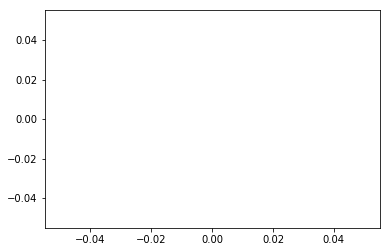

In [26]:
model

Yolov2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchnorm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [ ]:
start_lr = 0.0001

In [ ]:
class CosineAnnealingLR(_LRScheduler):

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]


In [ ]:
def train_last_layers(model, lr_est, n_cycles=1, epochs_per_cycle=1, cycle_mult=1):
#     sample_size = 1920
    train_loader, test_loader = get_data(batch_size=batch_size)

    metrics = {'train':{'loss':[], 'acc': []}, 'test': {'loss': [], 'acc': []}}
    # No Layer Groups
    opt = get_optimizer(model, [lr_est])
    
    meta['iteration'] = 0
    for cycle in range(n_cycles):
                
        # resetting the lr to original
        param_groups = opt.param_groups
        for param_group in param_groups:
            param_group['lr'] = lr_est

        cycle_len = meta['iterations_per_epoch'] * epochs_per_cycle
        sched = CosineAnnealingLR(opt, cycle_len)

        for epoch in range(epochs_per_cycle):
            
            for i, train_data in enumerate(train_loader):
                if train_data["image"].size(0) != batch_size:
                    break
                
                sched.step()
                loss, acc_map = train(model, train_data, opt, 0.3)
                loss_val = loss.data[0]
                acc_val = acc_map.data[0]
                metrics['train']['loss'].append(loss_val)
                metrics['train']['acc'].append(acc_val)
                
                meta['iteration'] += batch_size
                
                if meta['iteration']%(4*batch_size) == 0:
                    total_test_loss = []
                    total_test_acc = []
                    for i, test_data in enumerate(test_loader):
                        if test_data["image"].size(0) != batch_size:
                            break
                        
                        test_loss, test_acc = validate(model, test_data, 0.3)
                        total_test_loss.append(test_loss.data[0])
                        total_test_acc.append(test_acc.data[0])
                    
                    test_loss = np.mean(total_test_loss)
                    test_acc = np.mean(total_test_acc)
                    
                    metrics['test']['loss'].append(test_loss)
                    metrics['test']['acc'].append(test_acc)
                    print ("Iteration {0} Train Loss {1} Acc {2} Test Loss {3} Acc {4}".format(
                        meta['iteration'], loss_val, acc_val, test_loss, test_acc))
                    
                        
        epochs_per_cycle *= cycle_mult
    
    return model, metrics


In [ ]:
model = get_model()

In [ ]:
metrics = train_last_layers(model, start_lr)

In [ ]:
model.cpu()

In [ ]:
torch.save(model, open("model_2", "wb"))

In [ ]:
model = torch.load(open("model", "rb"))

In [ ]:
train_loader, test_loader = get_data(batch_size=batch_size)
for i, test_data in enumerate(test_loader):
    test_images = Variable(test_data["image"], requires_grad=True).cuda().float()
    test_labels = Variable(test_data["bboxes"], requires_grad=False).cuda().float()
    test_n_true = test_data["n_true"]
    break

In [ ]:
test_output = model(test_images)

In [ ]:
test_output

In [ ]:
nnms = get_nms_boxes(test_output, 0.24, 0.3)

In [ ]:
draw_bbox_torch({"image": test_images[0].cpu().data, "bboxes": test_labels[0].cpu().data})

In [ ]:
draw_bbox_nms(test_images[0].cpu(), nnms[0].cpu())

In [ ]:
torch.max(nnms[0][0][5:], 0)

In [ ]:
classes[7]

In [ ]:
list(model.children())

In [ ]:
list(model.children())[4].weight.data

In [ ]:
model2 = get_model()

In [ ]:
list(model2.children())[4].weight.data

In [ ]:
list(model.children())[0].weight.data

In [ ]:
def train_all_layers(model, lrs, layer_groups, n_cycles=1, epochs_per_cycle=1, cycle_mult=1):
    
    train_loader, test_loader = get_data()
    opt = get_optimizer(model, [lr_est/100, lr_est/10, lr_est], [16, 36, 43])
    metrics = {'train':{'loss':[], 'acc': []}, 'test': {'loss': [], 'acc': []}}
    # No Layer Groups
    opt = get_optimizer(model, [lr_est])
    
    meta['iteration'] = 0
    for cycle in range(n_cycles):
                
        # resetting the lr to original
        param_groups = opt.param_groups
        for param_group in param_groups:
            param_group['lr'] = lr_est

        cycle_len = meta['iterations_per_epoch'] * epochs_per_cycle
        sched = CosineAnnealingLR(opt, cycle_len)

        for epoch in range(epochs_per_cycle):
            
            for i, train_data in enumerate(train_loader):
                if train_data["image"].size(0) != batch_size:
                    break
                
                sched.step()
                loss, acc_map = train(model, train_data, opt)
                loss_val = loss.data[0]
                acc_val = acc_map.data[0]
                metrics['train']['loss'].append(loss_val)
                metrics['train']['acc'].append(acc_val)
                
                meta['iteration'] += batch_size
                
                if meta['iteration']%100 == 0:
                    total_test_loss = []
                    total_test_acc = []
                    for i, test_data in enumerate(test_loader):
                        if test_data["image"].size(0) != batch_size:
                            break
                        
                        test_loss, test_acc = validate(model, test_data)
                        total_test_loss.append(test_loss.data[0])
                        total_test_acc.append(test_acc.data[0])
                    
                    test_loss = np.mean(total_test_loss)
                    test_acc = np.mean(total_test_acc)
                    
                    metrics['test']['loss'].append(test_loss)
                    metrics['test']['acc'].append(test_acc)
                    print ("Iteration {0} Train Loss {1} Acc {2} Test Loss {3} Acc {4}".format(
                        meta['iteration'], loss_val, acc_val, test_loss, test_acc))
                    
                        
        epochs_per_cycle *= cycle_mult
    
    return model, metrics

    

In [ ]:
epochs = 10

for epoch in range(epochs):
#     import pdb; pdb.set_trace()
    for i, train_data in enumerate(train_loader):
        if train_data["image"].size(0) != batch_size:
            continue
        train_images = Variable(train_data["image"], requires_grad=True).cuda().float()
        train_labels = Variable(train_data["bboxes"], requires_grad=False).cuda().float()
        train_n_true = train_data["n_true"]
        
        sched.step()
        optimizer.zero_grad()
        
        current_lr = optimizer.param_groups[0]['lr']
        updated_lr = current_lr * 1.0223509385032303
        print ("current lr -- updated lr", current_lr, updated_lr)
        optimizer.param_groups[0]['lr'] = updated_lr
        train_output = model(train_images)
        
        try:
            loss = Yolov2Loss(train_output, train_labels, train_n_true.numpy())
        except Exception as e:
            print (iteration, i)
            raise e
        loss.backward()
        optimizer.step()
        lr_vals.append(updated_lr)
        loss_vals.append(loss.data[0])
        
        iteration += batch_size
        
        if iteration%2 == 0:
            
            test_total = 0
            test_total_map = torch.cuda.FloatTensor([0])
            for j, test_data in enumerate(test_loader):
                test_images = Variable(test_data["image"]).cuda().float()
                test_labels = Variable(test_data["bboxes"]).cuda().float()
                test_n_true = test_data["n_true"]
                
                test_output = model(test_images)
                test_nms = get_nms_detections(test_output, 0.4, 0.4)
                
                test_map = evaluation(test_labels, test_nms, test_n_true.numpy())
                test_total_map += test_map.data
                test_total += 1
            test_avg_map = test_total_map / test_total
            
            print ("Iteration {} loss {} accuracy {}".format(iteration, loss.data[0], test_avg_map))

In [ ]:
for i, b in enumerate(train_loader):
    img = b['image']
    bboxes = b['bboxes']
    break

draw_bbox_torch({"image": img[0], "bboxes":bboxes[0]})

out = model(Variable(img.float().cuda()))

iteration = 1
loss = Yolov2Loss(out, Variable(bboxes).cuda().float(), b['n_true'].numpy())

t = get_nms_detections(out)

mean_ap = evaluation(Variable(bboxes).float().cuda(), t, b['n_true'].numpy())